# Análise e Predição de Química entre Jogadores de Futebol

No futebol moderno, a performance coletiva vai além das métricas individuais como gols, passes certos ou desarmes. 
A interação entre os jogadores - a chamada "química" - é um fator crucial, mas frequentemente ignorado, especialmente 
em decisões de recrutamento. Casos como a contratação simultânea de Andy Carroll e Luis Suárez pelo Liverpool em 2011 
ilustram como a falta de entrosamento pode comprometer o desempenho, mesmo com atletas tecnicamente qualificados.

Este trabalho busca investigar a qualidade do entrosamento entre duplas de jogadores que atuaram juntas, utilizando 
dados de desempenho individual e coletivo. O objetivo é classificar o nível de química entre essas duplas e treinar 
um modelo capaz de prever a compatibilidade entre jogadores que nunca atuaram lado a lado.

Grupo: Gabriel Castelo, Matheus Vaz, Victor Kenji e Vinicius Gomes

Repositório no GitHub: [https://github.com/vinisilvag/cdaf-projeto](https://github.com/vinisilvag/cdaf-projeto)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import socceraction.spadl as spd

from bs4 import BeautifulSoup, Comment
import requests

pd.set_option('future.no_silent_downcasting', True)

### Scrapping de dados da FBref para enriquecer os dados que temos dos jogadores

A metodologia do trabalho de base usa dados proprietários. Assim, pretendemos contornar esse problema fazendo um scrapping de dados da FBref para enriquecer as informações dos jogadores e usar atributos semelhantes aos que eles utilizaram na nossa metodologia para cálculo das métricas e treinamento do modelo.

In [2]:
player_data = {
    "England": [
        ("https://fbref.com/en/comps/9/2017-2018/passing/2017-2018-Premier-League-Stats", "stats_passing"),
        ("https://fbref.com/en/comps/9/2017-2018/defense/2017-2018-Premier-League-Stats", "stats_defense"),
        ("https://fbref.com/en/comps/9/2017-2018/passing_types/2017-2018-Premier-League-Stats", "stats_passing_types"),
        ("https://fbref.com/en/comps/9/2017-2018/misc/2017-2018-Premier-League-Stats", "stats_misc"),
    ],
    "Spain": [
        ("https://fbref.com/en/comps/12/2017-2018/passing/2017-2018-La-Liga-Stats", "stats_passing"),
        ("https://fbref.com/en/comps/12/2017-2018/defense/2017-2018-La-Liga-Stats", "stats_defense"),
        ("https://fbref.com/en/comps/12/2017-2018/passing_types/2017-2018-La-Liga-Stats", "stats_passing_types"),
        ("https://fbref.com/en/comps/12/2017-2018/misc/2017-2018-La-Liga-Stats", "stats_misc"),
    ],
    "Germany": [
        ("https://fbref.com/en/comps/20/2017-2018/passing/2017-2018-Bundesliga-Stats", "stats_passing"),
        ("https://fbref.com/en/comps/20/2017-2018/defense/2017-2018-Bundesliga-Stats", "stats_defense"),
        ("https://fbref.com/en/comps/20/2017-2018/passing_types/2017-2018-Bundesliga-Stats", "stats_passing_types"),
        ("https://fbref.com/en/comps/20/2017-2018/misc/2017-2018-Bundesliga-Stats", "stats_misc"),
    ],
    "Italy": [
        ("https://fbref.com/en/comps/11/2017-2018/passing/2017-2018-Serie-A-Stats", "stats_passing"),
        ("https://fbref.com/en/comps/11/2017-2018/defense/2017-2018-Serie-A-Stats", "stats_defense"),
        ("https://fbref.com/en/comps/11/2017-2018/passing_types/2017-2018-Serie-A-Stats", "stats_passing_types"),
        ("https://fbref.com/en/comps/11/2017-2018/misc/2017-2018-Serie-A-Stats", "stats_misc"),
    ],
    "France": [
        ("https://fbref.com/en/comps/13/2017-2018/passing/2017-2018-Ligue-1-Stats", "stats_passing"),
        ("https://fbref.com/en/comps/13/2017-2018/defense/2017-2018-Ligue-1-Stats", "stats_defense"),
        ("https://fbref.com/en/comps/13/2017-2018/passing_types/2017-2018-Ligue-1-Stats", "stats_passing_types"),
        ("https://fbref.com/en/comps/13/2017-2018/misc/2017-2018-Ligue-1-Stats", "stats_misc"),
    ]
}

def get_data_by_league(league_data):
    scrapped_data = []
    for url, table_id in league_data:
        headers = {
            'User-Agent': 'Mozilla/5.0'
        }
        
        # Faz requisição
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # A tabela está dentro de um comentário HTML
        comments = soup.find_all(string=lambda text: isinstance(text, Comment))
        
        # Busca pela tabela dentro dos comentários
        table = None
        for comment in comments:
            comment_soup = BeautifulSoup(comment, 'html.parser')
            table = comment_soup.find('table', id=table_id)
            if table:
                break
        
        # Se tabela foi encontrada, extrair os dados
        if not table:
            raise ValueError(f'Table {table_id} not found!')
            
        # Extrair cabeçalhos
        headers = [th.text.strip() for th in table.find('thead').find_all('th')]
        headers = headers[1:]  # ignora a coluna do checkbox
        
        # Extrair dados do corpo da tabela
        data = []
        for row in table.find('tbody').find_all('tr'):
            # Ignora linhas de subtítulos
            if row.get('class') and 'thead' in row.get('class'):
                continue
            cells = [td.text.strip() for td in row.find_all('td')]
            if cells:
                data.append(dict(zip(headers, cells)))
        
        # Converter para DataFrame
        df = pd.DataFrame(data)
        scrapped_data.append(df)
    return scrapped_data

### Exemplo do scrapping para a Premier League

Para as outras ligas a ideia permanece a mesma, faltando apenas corrigir a captura dos headers da tabela, conectar os dados obtidos com cada player e filtrar exatamente o que iremos utilizar no cálculo das métricas de entrosamento/treinamento do modelo. A ideia é que uma vez que o script esteja pronto, os dados serão lidos e salvos num .csv separado, para evitar ter que realizar o scrapping com frequência e problemas caso o site atualize.

In [3]:
england_players_scrapped_data = get_data_by_league(player_data["England"])

In [4]:
# Dados de passe
england_players_scrapped_data[0]

,Total,Short,Medium,Long,,Expected,Rk,Player,Nation,Pos,Squad,Age,Born,90s,Cmp,Att,Cmp%,TotDist,PrgDist,Ast
0,Patrick van Aanholt,nl NED,DF,Crystal Palace,884,1990,1176,75.2,14197,6422,479,532,90.0,311,28,6,92,152,48.7,Matches
1,Rolando Aarons,eng ENG,"MF,FW",Newcastle Utd,29,1995,44,65.9,376,77,24,30,80.0,2,1,1,3,3,66.7,Matches
2,Tammy Abraham,eng ENG,FW,Swansea City,206,1997,314,65.6,2754,557,123,173,71.1,56,6,2,20,22,45.5,Matches
3,Charlie Adam,sct SCO,MF,Stoke City,168,1985,285,58.9,3889,1505,51,66,77.3,72,7,4,30,107,42.1,Matches
4,Adrián,es ESP,GK,West Ham,266,1987,571,46.6,11798,10438,12,12,100.0,51,1,0,0,503,40.4,Matches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,Wilfried Zaha,ci CIV,"FW,MF",Crystal Palace,497,1992,716,69.4,6815,2094,291,365,79.7,149,49,7,96,52,46.2,Matches
525,Davide Zappacosta,it ITA,"DF,MF",Chelsea,514,1992,660,77.9,7506,1763,297,322,92.2,164,14,13,22,49,57.1,Matches
526,Marvin Zeegelaar,nl NED,DF,Watford,436,1990,584,74.7,6677,3045,259,297,87.2,140,10,7,54,55,50.9,Matches
527,Oleksandr Zinchenko,ua UKR,DF,Manchester City,664,1996,729,91.1,9453,2333,391,414,94.4,218,8,0,57,46,67.4,Matches


In [5]:
# Dados de ações defensivas
england_players_scrapped_data[1]

,Tackles,Challenges,Blocks,,Rk,Player,Nation,Pos,Squad,Age,...,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Att,Tkl%,Lost,Sh
0,Patrick van Aanholt,nl NED,2,26,1990,24.3,47,32,29,15,...,16,19,47.1,18,24,5,47,94,64,Matches
1,Rolando Aarons,eng ENG,0,21,1995,1.5,4,4,3,1,...,4,3,66.7,2,3,0,1,5,0,Matches
2,Tammy Abraham,eng ENG,0,19,1997,19.2,10,8,1,7,...,1,7,7.7,12,8,1,1,11,11,Matches
3,Charlie Adam,sct SCO,2,31,1985,4.6,9,5,2,5,...,5,2,29.4,12,2,0,9,18,11,Matches
4,Adrián,es ESP,1,30,1987,19.0,2,1,2,0,...,1,1,25.0,3,1,0,0,2,15,Matches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,Wilfried Zaha,ci CIV,0,24,1992,28.3,30,23,9,13,...,4,24,17.4,19,24,0,7,37,4,Matches
525,Davide Zappacosta,it ITA,0,25,1992,12.2,26,11,14,9,...,11,9,44.0,14,11,2,6,32,26,Matches
526,Marvin Zeegelaar,nl NED,0,26,1990,11.0,23,18,15,3,...,11,4,45.8,13,5,1,20,43,30,Matches
527,Oleksandr Zinchenko,ua UKR,0,20,1996,5.9,23,16,11,9,...,7,3,53.8,6,3,0,6,29,7,Matches


In [6]:
# Dados de tipos de passe
england_players_scrapped_data[2]

,Pass Types,Corner Kicks,Outcomes,,Rk,Player,Nation,Pos,Squad,Age,...,Live,Dead,FK,TB,Sw,Crs,TI,CK,In,Out
0,Patrick van Aanholt,nl NED,DF,Crystal Palace,26,1990,24.3,1176,897,276,...,56,235,11,3,5,2,884,3,31,Matches
1,Rolando Aarons,eng ENG,"MF,FW",Newcastle Utd,21,1995,1.5,44,41,2,...,2,0,0,0,0,0,29,1,3,Matches
2,Tammy Abraham,eng ENG,FW,Swansea City,19,1997,19.2,314,286,28,...,13,1,0,0,0,0,206,0,6,Matches
3,Charlie Adam,sct SCO,MF,Stoke City,31,1985,4.6,285,252,28,...,30,4,10,3,4,3,168,5,9,Matches
4,Adrián,es ESP,GK,West Ham,30,1987,19.0,571,332,235,...,0,0,0,0,0,0,266,4,0,Matches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,Wilfried Zaha,ci CIV,"FW,MF",Crystal Palace,24,1992,28.3,716,695,18,...,76,14,0,0,0,0,497,3,39,Matches
525,Davide Zappacosta,it ITA,"DF,MF",Chelsea,25,1992,12.2,660,526,131,...,84,128,1,0,0,0,514,3,33,Matches
526,Marvin Zeegelaar,nl NED,DF,Watford,26,1990,11.0,584,453,131,...,38,124,1,0,1,0,436,0,27,Matches
527,Oleksandr Zinchenko,ua UKR,DF,Manchester City,20,1996,5.9,729,678,51,...,10,47,0,0,0,0,664,0,8,Matches


In [7]:
# Outros dados
england_players_scrapped_data[3]

,Performance,Aerial Duels,,Rk,Player,Nation,Pos,Squad,Age,Born,...,Fls,Fld,Off,Crs,Int,TklW,PKwon,PKcon,OG,Recov
0,Patrick van Aanholt,nl NED,DF,Crystal Palace,26,1990,24.3,7,0,0,...,47,32,0,0,0,162,6,5,54.5,Matches
1,Rolando Aarons,eng ENG,"MF,FW",Newcastle Utd,21,1995,1.5,0,0,0,...,1,4,0,0,0,9,1,3,25.0,Matches
2,Tammy Abraham,eng ENG,FW,Swansea City,19,1997,19.2,0,0,0,...,1,8,0,0,0,41,39,58,40.2,Matches
3,Charlie Adam,sct SCO,MF,Stoke City,31,1985,4.6,2,1,0,...,9,5,0,0,0,40,7,4,63.6,Matches
4,Adrián,es ESP,GK,West Ham,30,1987,19.0,2,0,0,...,0,1,0,0,0,20,2,1,66.7,Matches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,Wilfried Zaha,ci CIV,"FW,MF",Crystal Palace,24,1992,28.3,5,0,0,...,7,23,4,0,0,124,4,15,21.1,Matches
525,Davide Zappacosta,it ITA,"DF,MF",Chelsea,25,1992,12.2,0,0,0,...,6,11,0,0,0,67,14,6,70.0,Matches
526,Marvin Zeegelaar,nl NED,DF,Watford,26,1990,11.0,4,1,0,...,20,18,0,0,0,63,12,8,60.0,Matches
527,Oleksandr Zinchenko,ua UKR,DF,Manchester City,20,1996,5.9,1,0,0,...,6,16,0,0,0,32,16,3,84.2,Matches


### Funções úteis

In [8]:
def load_matches(path):
    matches = pd.read_json(path_or_buf=path)
    # as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
    team_matches = []
    for i in range(len(matches)):
        match = pd.DataFrame(matches.loc[i, 'teamsData']).T
        match['matchId'] = matches.loc[i, 'wyId']
        team_matches.append(match)
    team_matches = pd.concat(team_matches).reset_index(drop=True)
    return team_matches

def load_players(path):
    players = pd.read_json(path_or_buf=path)
    players['player_name'] = players['firstName'] + ' ' + players['lastName']
    players = players[['wyId', 'player_name', 'passportArea', 'role']].rename(columns={'wyId': 'player_id'})
    return players

def load_events(path):
    events = pd.read_json(path_or_buf=path)
    # pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
    events = events.rename(columns={
        'id': 'event_id',
        'eventId': 'type_id',
        'subEventId': 'subtype_id',
        'teamId': 'team_id',
        'playerId': 'player_id',
        'matchId': 'game_id'
    })
    events['milliseconds'] = events['eventSec'] * 1000
    events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})
    return events

# def load_minutes_played_per_game(path):
#     minutes = pd.read_json(path_or_buf=path)
#     minutes = minutes.rename(columns={
#         'playerId': 'player_id',
#         'matchId': 'game_id',
#         'teamId': 'team_id',
#         'minutesPlayed': 'minutes_played'
#     })
#     minutes = minutes.drop(['shortName', 'teamName', 'red_card'], axis=1)
#     return minutes

In [9]:
leagues = ['England', 'Spain', 'Germany', 'Italy', 'France']
events = {}
matches = {}
for league in tqdm(leagues):
    path = r'data/matches/matches_{}.json'.format(league)
    matches[league] = load_matches(path)
    path = r'data/events/events_{}.json'.format(league)
    events[league] = load_events(path)

path = r'data/players.json'
players = load_players(path)
players['player_name'] = players['player_name'].str.decode('unicode-escape')

100%|███████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.66s/it]


## Mapeamento para SPADL

In [10]:
def spadl_transform(events, matches):
    spadl = []
    game_ids = events.game_id.unique().tolist()
    for g in tqdm(game_ids):
        match_events = events.loc[events.game_id == g]
        match_home_id = matches.loc[(matches.matchId == g) & (matches.side == 'home'), 'teamId'].values[0]
        match_actions = spd.wyscout.convert_to_actions(events=match_events, home_team_id=match_home_id)
        match_actions = spd.play_left_to_right(actions=match_actions, home_team_id=match_home_id)
        match_actions = spd.add_names(match_actions)
        spadl.append(match_actions)
    spadl = pd.concat(spadl).reset_index(drop=True)
    return spadl

In [11]:
spadl = {}
for league in leagues:
    spadl[league] = spadl_transform(events=events[league], matches=matches[league])
    # Adicionando o nome dos players
    spadl[league] = spadl[league].merge(players[['player_id', 'player_name']], on='player_id', how='left')

100%|███████████████████████████████████████████████| 380/380 [05:04<00:00,  1.25it/s]


## Análise exploratória

In [12]:
spadl['England']

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name
0,2499719,1,2.758649,1609,25413,51.45,34.68,32.55,14.96,177959171,0,0,1,0,pass,success,foot,Alexandre Lacazette
1,2499719,1,4.946850,1609,370224,32.55,14.96,53.55,17.00,177959172,0,0,1,1,pass,success,foot,Rob Holding
2,2499719,1,6.542188,1609,3319,53.55,17.00,36.75,19.72,177959173,1,0,1,2,pass,success,head,Mesut Özil
3,2499719,1,8.143395,1609,120339,36.75,19.72,43.05,3.40,177959174,1,0,1,3,pass,success,head,Mohamed Naser Elsayed Elneny
4,2499719,1,10.302366,1609,167145,43.05,3.40,75.60,8.16,177959175,0,0,1,4,pass,success,foot,Héctor Bellerín Moruno
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483894,2500098,2,2785.702032,1633,20620,55.65,7.48,103.95,19.04,251596226,0,0,1,1136,pass,success,foot,Pedro Mba Obiang Avomo
483895,2500098,2,2789.232666,1633,14703,103.95,19.04,103.95,19.04,251596229,5,1,0,1137,cross,fail,foot_right,Marko Arnautović
483896,2500098,2,2790.457942,1623,8239,2.10,46.92,0.00,46.24,251596408,0,10,1,1138,interception,success,foot,Leighton Baines
483897,2500098,2,2829.821084,1633,70965,105.00,0.00,92.40,36.04,251596232,0,5,1,1139,corner_crossed,success,foot,João Mário Naval da Costa Eduardo


In [13]:
spadl['Spain']

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name
0,2565548,1,2.994582,682,3542,38.85,26.52,52.50,34.00,180864419,0,0,1,0,pass,success,foot,Manuel Trigueros Muñoz
1,2565548,1,3.137020,682,274435,52.50,34.00,47.25,47.60,180864418,0,0,1,1,pass,success,foot,Enes Ünal
2,2565548,1,6.709668,682,364860,47.25,47.60,39.90,59.84,180864420,0,0,1,2,pass,success,foot,Rodrigo Hernández Cascante
3,2565548,1,8.805497,682,3534,39.90,59.84,33.60,21.08,180864421,0,0,1,3,pass,success,foot,Jaume Vicent Costa Jordá
4,2565548,1,14.047492,682,3695,33.60,21.08,32.55,42.84,180864422,0,0,1,4,pass,success,foot,Álvaro González Soberón
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474717,2565927,2,2940.515560,682,122832,92.40,66.64,101.85,53.72,253302673,0,21,1,1479,dribble,success,foot,Salem Mohammed Al Dawsari
474718,2565927,2,2942.098761,682,122832,101.85,53.72,96.60,50.32,253302674,4,1,0,1480,cross,fail,foot_left,Salem Mohammed Al Dawsari
474719,2565927,2,2943.089232,675,40756,8.40,17.68,9.45,29.92,253302698,0,0,1,1481,pass,success,foot,Carlos Henrique Casimiro
474720,2565927,2,2943.668846,675,3306,9.45,29.92,9.45,29.92,253302695,0,10,1,1482,interception,success,foot,Sergio Ramos García


In [14]:
spadl['Germany']

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name
0,2516739,1,2.409746,2446,15231,52.50,34.00,52.50,35.36,179896442,0,0,1,0,pass,success,foot,Kevin Volland
1,2516739,1,2.506082,2446,14786,52.50,35.36,23.10,53.04,179896443,0,0,1,1,pass,success,foot,Karim Bellarabi
2,2516739,1,6.946706,2446,14803,23.10,53.04,6.30,36.72,179896444,0,0,1,2,pass,success,foot,Sven Bender
3,2516739,1,10.786491,2446,14768,6.30,36.72,21.00,61.20,179896445,0,0,1,3,pass,success,foot,Bernd Leno
4,2516739,1,12.684514,2446,14803,21.00,61.20,28.35,65.28,179896446,0,0,1,4,pass,success,foot,Sven Bender
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389146,2517044,2,2817.761761,2463,94831,87.15,36.72,87.15,36.72,251206865,5,11,0,1148,shot,fail,foot_right,Yūya Ōsako
389147,2517044,2,2818.280436,2451,14917,17.85,31.96,23.10,27.20,251206783,0,10,1,1149,interception,success,foot,Robin Knoche
389148,2517044,2,2823.180681,2451,14804,23.10,27.20,0.00,3.40,NaN,0,21,1,1150,dribble,success,foot,Jakub Błaszczykowski
389149,2517044,2,2828.080925,2451,14804,0.00,3.40,5.25,4.76,251206790,0,0,0,1151,pass,fail,foot,Jakub Błaszczykowski


In [15]:
spadl['Italy']

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name
0,2575959,1,2.530536,3158,8327,51.45,32.64,45.15,38.08,180423957,0,0,1,0,pass,success,foot,Edin Džeko
1,2575959,1,3.768418,3158,20438,45.15,38.08,37.80,56.44,180423958,0,0,1,1,pass,success,foot,Daniele De Rossi
2,2575959,1,5.941547,3158,8306,37.80,56.44,81.90,29.92,NaN,0,21,1,2,dribble,success,foot,Aleksandar Kolarov
3,2575959,1,8.114676,3158,8306,81.90,29.92,67.20,57.80,180423960,0,7,1,3,take_on,success,foot,Aleksandar Kolarov
4,2575959,1,8.647892,3158,8306,67.20,57.80,75.60,57.80,180423961,0,7,1,4,take_on,success,foot,Aleksandar Kolarov
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495868,2576338,2,2812.814903,3193,345740,70.35,19.72,73.50,50.32,253567149,0,0,0,1227,pass,fail,foot,Pedro Miguel Almeida Lopes Pereira
495869,2576338,2,2823.098572,3193,116269,77.70,55.76,79.80,59.16,253567155,0,7,1,1228,take_on,success,foot,Diego Sebastián Laxalt Suárez
495870,2576338,2,2823.371314,3185,21234,27.30,12.24,25.20,8.84,253567158,0,7,0,1229,take_on,fail,foot,Andrea Belotti
495871,2576338,2,2824.741855,3185,21234,25.20,8.84,25.20,8.84,253567159,0,8,0,1230,foul,fail,foot,Andrea Belotti


In [16]:
spadl['France']

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,bodypart_id,type_id,result_id,action_id,type_name,result_name,bodypart_name,player_name
0,2500686,1,1.935181,3799,253784,52.50,33.32,32.55,36.72,176505119,0,0,1,0,pass,success,foot,Baptiste Guillaume
1,2500686,1,3.599295,3799,29474,32.55,36.72,71.40,17.68,176505121,0,0,1,1,pass,success,foot,Romain Thomas
2,2500686,1,8.471820,3799,26265,71.40,17.68,70.35,13.60,NaN,0,21,1,2,dribble,success,foot,Vincent Manceau
3,2500686,1,13.344344,3799,26265,70.35,13.60,76.65,27.20,176505132,0,10,1,3,interception,success,foot,Vincent Manceau
4,2500686,1,13.710413,3772,56441,28.35,40.80,35.70,40.80,176505021,0,0,1,4,pass,success,foot,Lukas Lerager
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476780,2501065,2,2816.954783,19830,3450,77.70,29.92,92.40,19.72,253316974,0,0,1,1333,pass,success,foot,Radamel Falcao García Zárate
476781,2501065,2,2821.203869,19830,405977,91.35,23.80,105.00,37.40,253316980,4,11,1,1334,shot,success,foot_left,Jordi Mboula Queralt
476782,2501065,2,2888.383858,3795,295761,52.50,32.64,46.20,36.04,253316981,0,0,1,1335,pass,success,foot,Samuel Grandsir
476783,2501065,2,2889.654402,3795,249926,46.20,36.04,43.05,62.56,253316982,0,0,1,1336,pass,success,foot,Alois Confais


### Players

In [17]:
players_england = spadl['England']['player_name'].unique()
print("Número de jogadores na Premier League:", len(players_england))
players_england

Número de jogadores na Premier League: 514


array(['Alexandre Lacazette', 'Rob Holding', 'Mesut Özil',
       'Mohamed Naser Elsayed Elneny', 'Héctor Bellerín Moruno',
       'Harry  Maguire', 'Granit Xhaka', 'Sead Kolašinac',
       'Ignacio Monreal Eraso', 'Marc Albrighton',
       'Onyinye Wilfred Ndidi', 'Christian Fuchs', 'Shinji Okazaki',
       'Petr Čech', 'Daniel Nii Tackie Mensah Welbeck', 'Wes Morgan', nan,
       'Alex Oxlade-Chamberlain', 'Riyad Mahrez', 'Jamie Vardy',
       'Kasper Schmeichel', 'Matty James', 'Danny Simpson',
       'Aaron Ramsey', 'Olivier Giroud', 'Daniel Amartey',
       'Theo  Walcott', 'Kelechi Promise Iheanacho', 'Demarai Gray',
       'Sergio Leonel Agüero del Castillo', 'Fernando Luiz Rosa',
       'Nicolás Hernán Otamendi', 'Vincent Kompany', 'John Stones',
       'Lewis Dunk', 'Kyle Walker', 'Isaiah Brown', 'Tomer Hemed',
       'Ederson Santana de Moraes', 'Dale Stephens', 'Solly March',
       'Bruno Saltor Grau', 'Danilo Luiz da Silva', 'Pascal Groß',
       'Kevin De Bruyne', 'David 

In [18]:
players_spain = spadl['Spain']['player_name'].unique()
print("Número de jogadores na La Liga:", len(players_spain))
players_spain

Número de jogadores na La Liga: 557


array(['Manuel Trigueros Muñoz', 'Enes Ünal',
       'Rodrigo Hernández Cascante', 'Jaume Vicent Costa Jordá',
       'Álvaro González Soberón', 'Víctor Ruíz Torre',
       'Andrés Eduardo Fernández Moreno', 'Antonio Rukavina',
       'Nicola Sansone', 'Sergio Postigo Redondo',
       'José Luis Morales Nogales', 'Enis Bardhi',
       'Jefferson Andrés Lerma Solís', 'José Ángel Gómez Campaña',
       'Antonio García Aranda', 'José Manuel Rodríguez Benito',
       'Iván López Mendoza', 'Raúl Fernández-Cavada Mateos',
       'Alexander Alegría Moreno', 'David Remeseiro Salgueiro',
       'Carlos Arturo Bacca Ahumada', 'Pablo Fornals Malla', nan,
       'Leonardo Gabriel Suárez', 'Cheick Doukouré', 'Iván López Álvarez',
       "Alfred John Momar N'Diaye", 'Emmanuel Okyere Boateng',
       'Darío Poveda Romera', 'Willian José da Silva',
       'Asier Illarramendi Andonegi', 'Raúl Rodríguez Navas',
       'Aritz Elustondo Irribaria', 'Gerónimo Rulli',
       'Kévin Manuel Rodrigues', 'Hugo 

In [19]:
players_germany = spadl['Germany']['player_name'].unique()
print("Número de jogadores na Bundesliga:", len(players_germany))
players_germany

Número de jogadores na Bundesliga: 473


array(['Kevin Volland', 'Karim Bellarabi', 'Sven Bender', 'Bernd Leno',
       'Wendell Nascimento Borges', 'Sebastian Rudy', 'Thomas Müller',
       'Corentin Tolisso', 'Charles Mariano Aránguiz Sandoval',
       'Arturo Erasmo Vidal Pardo', 'Jonathan Tah', 'Niklas Süle',
       'David Olatukunbo Alaba', 'Robert Lewandowski', 'Joshua Kimmich',
       'Franck Bilal Ribéry', 'Admir Mehmedi', 'Dominik Kohr',
       'Leon Bailey Butler', 'Mats  Hummels', 'Sven Ulreich',
       'Benjamin Henrichs', nan, 'Julian Brandt', 'Aleksandar Dragović',
       'Kevin Kampl', 'Márcio Rafael Ferreira de Souza', 'Arjen Robben',
       'Kingsley Coman', 'Max Kruse', 'Maximilian Eggestein',
       'Robert Bauer', 'Florian Kainz', 'Steven Zuber', 'Kevin Vogt',
       'Benjamin Hübner', 'Dennis Geiger', 'Håvard Nordtveit',
       'Jeremy Toljan', 'Nadiem Amiri', 'Thomas Delaney',
       'Hans Carl Ludwig Augustinsson', 'Kerem Demirbay', 'Mark Uth',
       'Theodor Gebre Selassie', 'Ádám Szalai', 'Jiří Pavle

In [20]:
players_italy = spadl['Italy']['player_name'].unique()
print("Número de jogadores na Serie A:", len(players_italy))
players_italy

Número de jogadores na Serie A: 534


array(['Edin Džeko', 'Daniele De Rossi', 'Aleksandar Kolarov',
       'José Luis Palomino', 'Juan Guilherme Nunes Jesus',
       'Diego Perotti', 'Etrit Berisha', 'Robin Gosens',
       'Alejandro Darío Gómez', 'Remo Freuler', 'Konstantinos Manolas',
       'Andrea Masiello', 'Rafael Tolói', 'Bryan Cristante',
       'Alisson Ramsés Becker', 'Kevin Strootman', 'Gregoire  Defrel',
       'Bruno da Silva Peres', 'Radja Nainggolan', nan, 'Hans Hateboer',
       'Andrea Petagna', 'Jasmin Kurtič', 'Andreas Evald Cornelius',
       'Josip Iličić', 'Marten de Roon', 'Federico Julián Fazio',
       'Stephan El Shaarawy', 'Federico Di Francesco', 'Domenico Maietta',
       'Sebastien De Maio', 'Antonio Mirante', 'Davide Zappacosta',
       "Nicolas N'Koulou", 'Emiliano Moretti', 'Afriyie Acquah',
       'Vassilis Torosidis', 'Cristian Molinaro', 'Saphir Sliti Taïder',
       'Adam Masina', 'Iago Falqué Silva', 'Andrea Belotti',
       'Joel Chukwuma Obi', 'Erick Antonio Pulgar Farfán', 'Andrea 

In [21]:
players_france = spadl['France']['player_name'].unique()
print("Número de jogadores na Ligue 1:", len(players_france))
players_france

Número de jogadores na Ligue 1: 542


array(['Baptiste Guillaume', 'Romain Thomas', 'Vincent Manceau',
       'Lukas Lerager', 'Younousse Sankharé', 'Alexandre Letellier',
       'Ismaël Traoré', 'Baptiste Santamaria', 'Vukašin Jovanović',
       'Jérémy Toulalan', 'Benoît Costil', 'Valentín Vada',
       'Youssouf Sabaly', 'Malcom Filipe Silva de Oliveira',
       'Pierrick Capelle', nan, 'Théo Pellenard', 'Thomas Mangani',
       'François Kamano', 'Gilles Sunu', 'Lassana Coulibaly',
       'Angelo Fulgini', 'Alexandre Mendy', 'Karl Toko Ekambi',
       'Flavien Tait', 'Jaroslav Plašil', 'Mateo Pavlović',
       'Gaëtan  Laborde', 'Thomas Touré', 'Emiliano Sala',
       'Préjuce Niguimbé Nakoulma', 'Diego Carlos Santos Silva',
       'Júnior Osmar Ignacio  Alonso Mujica',
       'Luiz de Araújo Guimarães Neto', 'Nicolas de Roussel de Préville',
       'Valentin Rongier', 'Abdoulaye Touré', 'Alexander Kačaniklić',
       'Mike Maignan', 'Fodé  Ballo Touré', 'Lévy Koffi Djidji',
       'Nicolas Pallois', 'Thiago Henrique M

### Número médio de ações por jogo em cada liga

Observações
- Mais ou menos o mesmo número médio de ações por jogo.

In [22]:
spadl['England'].groupby('game_id').size().mean()

1273.4184210526316

In [23]:
spadl['Spain'].groupby('game_id').size().mean()

1249.2684210526315

In [24]:
spadl['Germany'].groupby('game_id').size().mean()

1271.735294117647

In [25]:
spadl['Italy'].groupby('game_id').size().mean()

1304.928947368421

In [26]:
spadl['France'].groupby('game_id').size().mean()

1254.6973684210527

### Distribuição dos Tipos de Ação

Histograma com a frequência ded cada tipo de ação existente nos dados analisados.

Observações:
- Passe é a ação mais comum;
- Alternância, a depender da liga, entre interceptações e bolas carregadas como segundo tipo de ação mais realizada;
- Ocorrências menos frequentes de lançamentos, cruzamentos, "chutões" e desarmes.

In [27]:
def plot_action_counts(action_counts):
    plt.figure(figsize=(10, 6))
    action_counts.plot(kind='bar', color='skyblue')
    plt.title('Distribuição dos Tipos de Ação')
    plt.xlabel('Tipo de Ação')
    plt.ylabel('Frequência')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

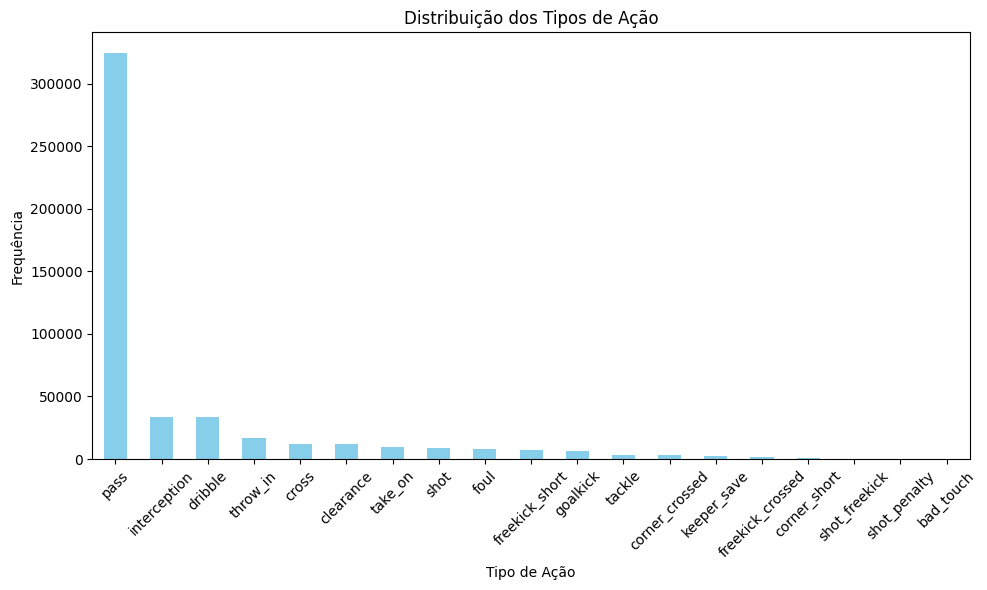

In [28]:
plot_action_counts(spadl['England']['type_name'].value_counts())

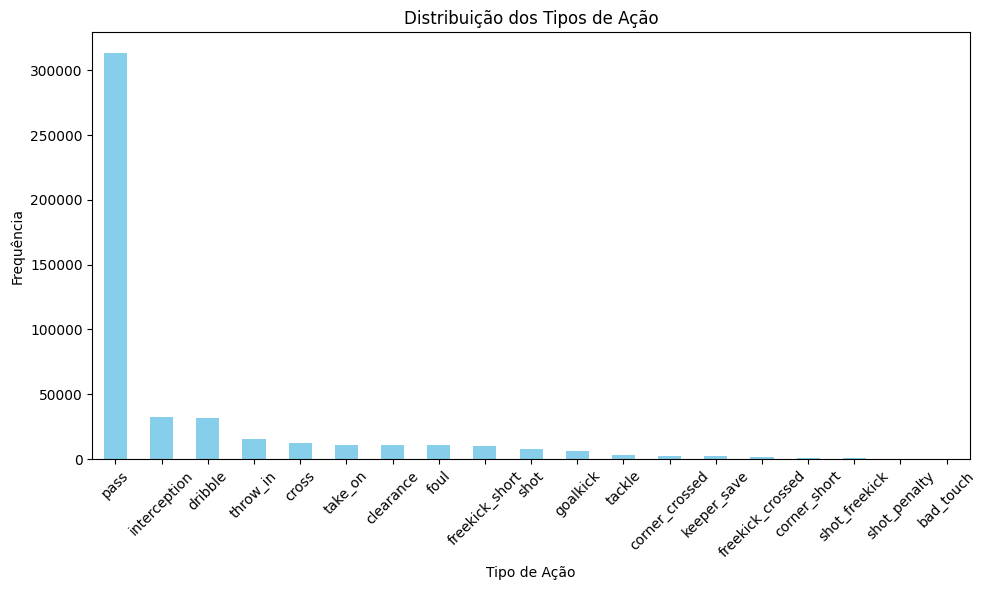

In [29]:
plot_action_counts(spadl['Spain']['type_name'].value_counts())

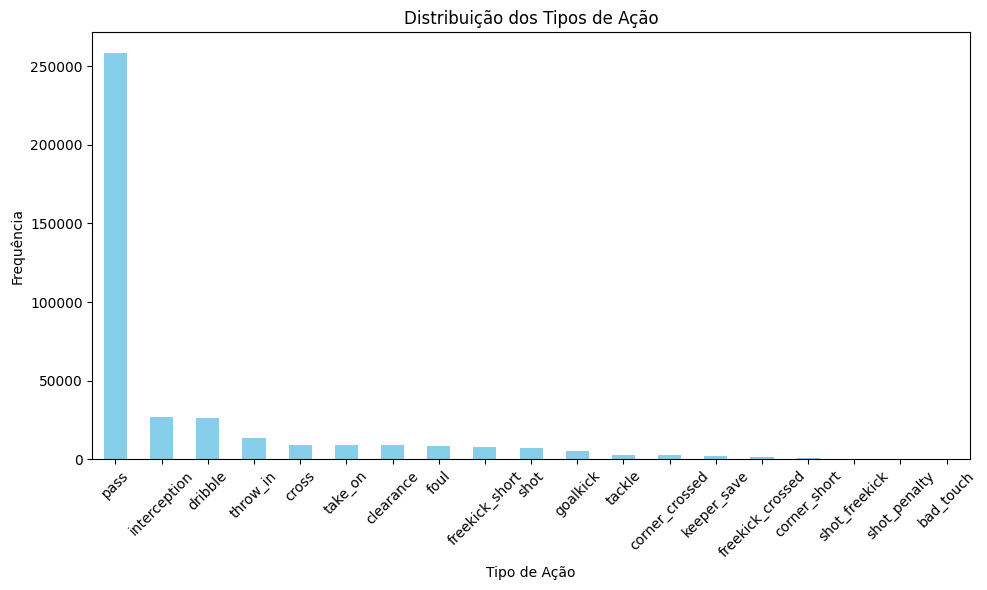

In [30]:
plot_action_counts(spadl['Germany']['type_name'].value_counts())

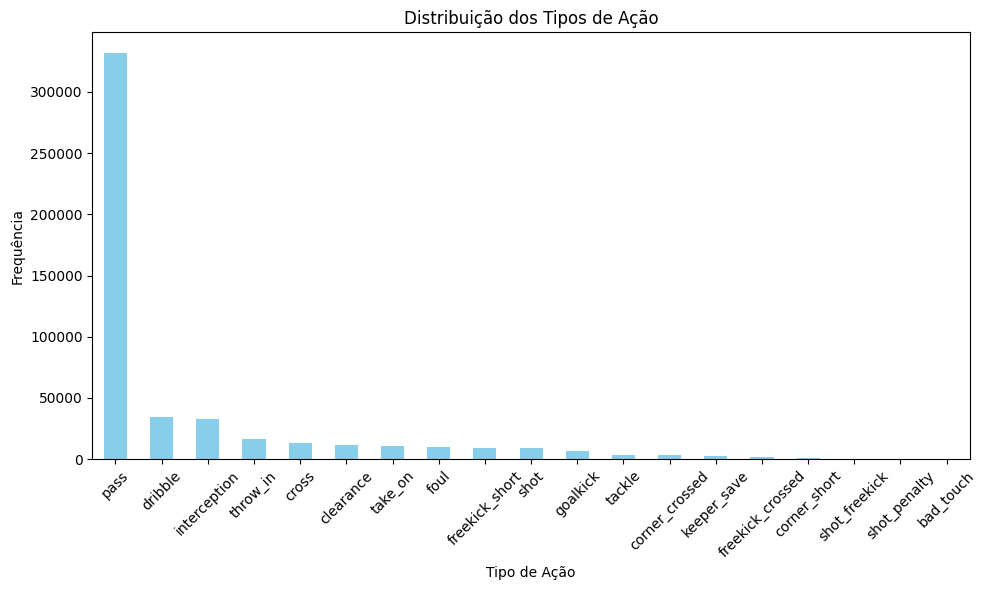

In [31]:
plot_action_counts(spadl['Italy']['type_name'].value_counts())

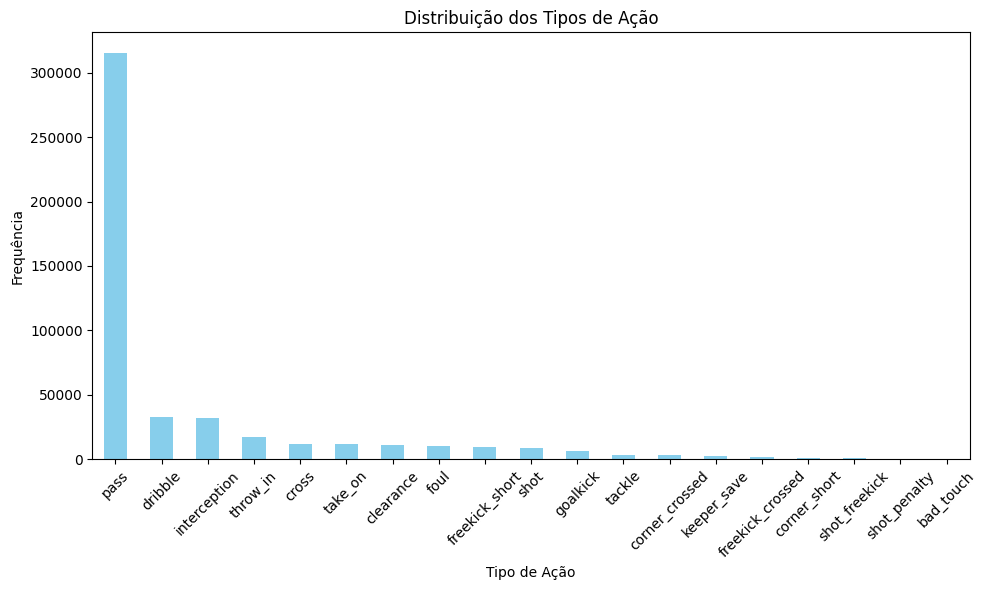

In [32]:
plot_action_counts(spadl['France']['type_name'].value_counts())

### Ações por Jogador

Top 10 jogadores com mais ações registradas na liga.

Observações:
- Os jogadores mais participativos são, em geral, meio campistas ou jogadores muito importantes do time;
- O número de ações parece flutuar pouco.

In [33]:
def plot_top_active_players(top_players):
    plt.figure(figsize=(10, 6))
    top_players.plot(kind='bar', color='lightgreen')
    plt.title('Top 10 Jogadores por Número de Ações')
    plt.xlabel('Jogador')
    plt.ylabel('Número de Ações')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

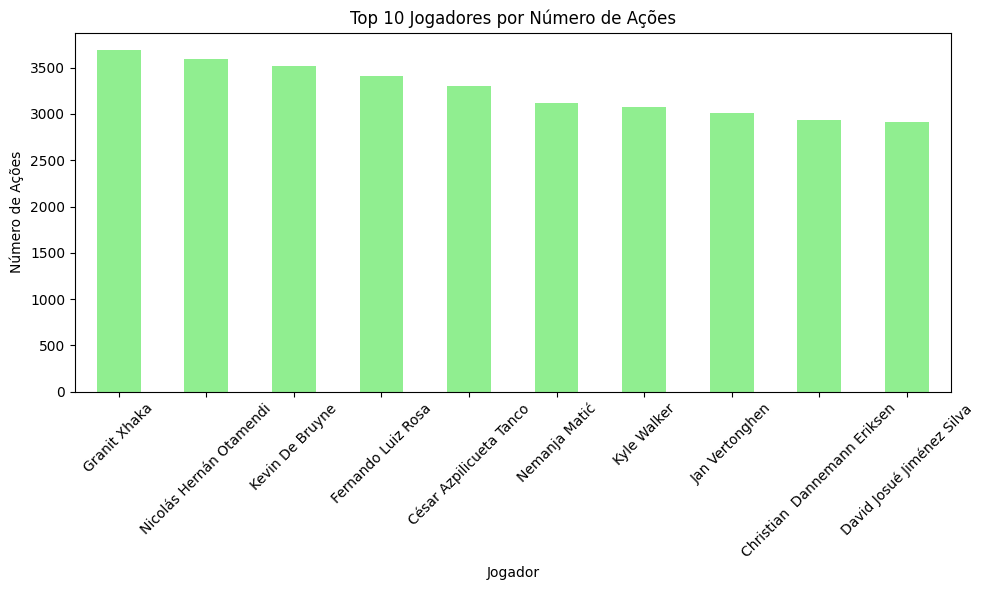

In [34]:
plot_top_active_players(spadl['England']['player_name'].value_counts().head(10))

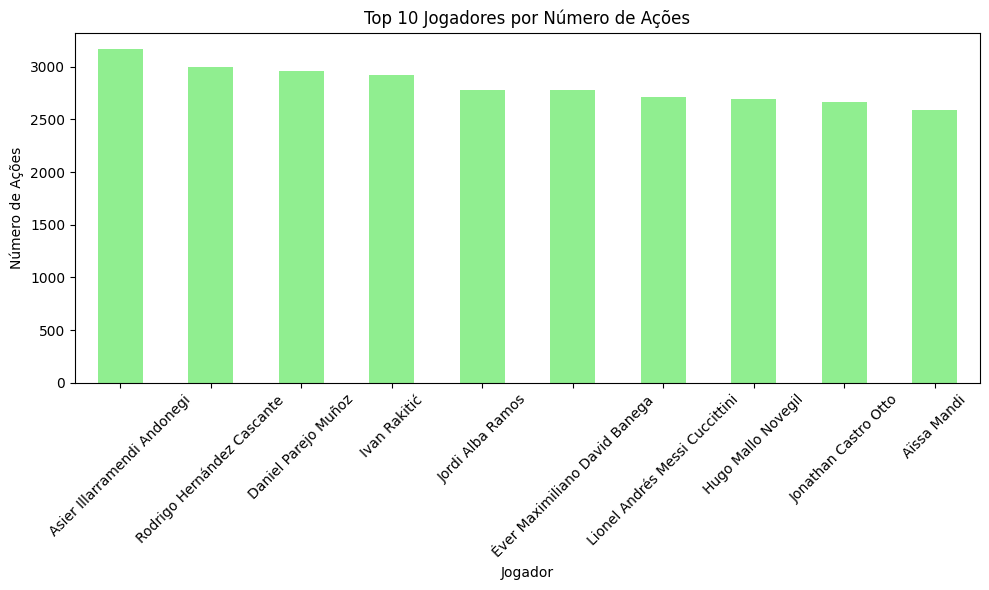

In [35]:
plot_top_active_players(spadl['Spain']['player_name'].value_counts().head(10))

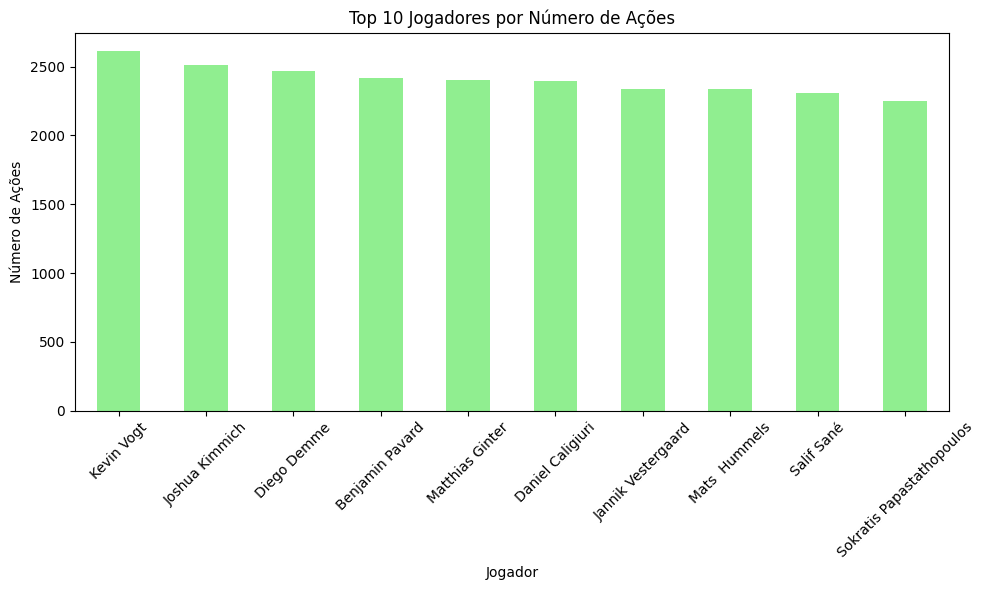

In [36]:
plot_top_active_players(spadl['Germany']['player_name'].value_counts().head(10))

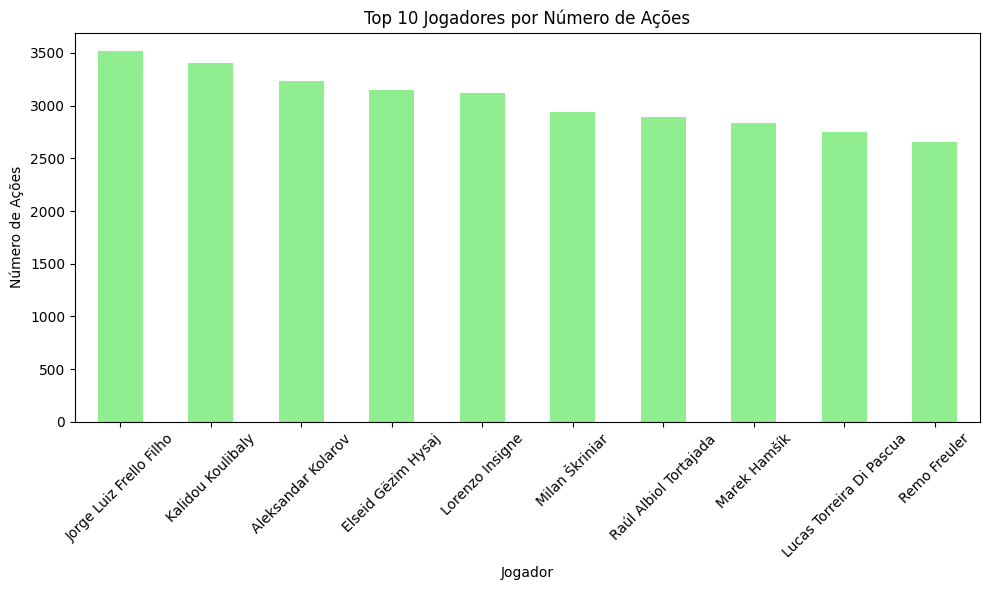

In [37]:
plot_top_active_players(spadl['Italy']['player_name'].value_counts().head(10))

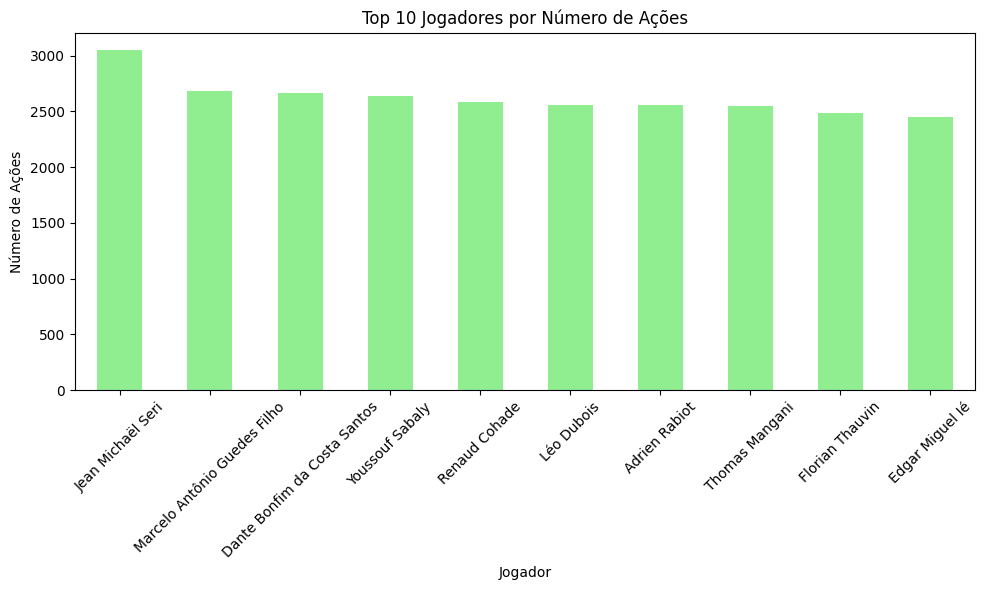

In [38]:
plot_top_active_players(spadl['France']['player_name'].value_counts().head(10))

### Mapa de Calor dos Passes

Mapa de calor dos passes em função das áreas do campo.

Observações:
- A troca de passes nas 5 ligas segue mais ou menos a mesma distribuição pelo campo;
- Pouca troca de passe na área adversária;
- Parece comum a existência de um jogador no meio do campo que distribui e conecta a bola entre a defesa e o ataque.

In [39]:
def plot_pass_heatmap(passes):
    n_x, n_y = 24, 16
    x_bins = np.linspace(0, 105, n_x + 1)
    y_bins = np.linspace(0, 68, n_y + 1)
    
    # Conta quantos passes começaram em cada quadrante
    heatmap, _, _ = np.histogram2d(passes['start_y'], passes['start_x'], bins=[y_bins, x_bins])
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 7))
    im = ax.imshow(heatmap, cmap='Blues', origin='lower', extent=[0, 105, 0, 68], aspect='auto')
    
    # Adiciona a grade
    for x in x_bins:
        ax.axvline(x, color='gray', linewidth=0.5)
    for y in y_bins:
        ax.axhline(y, color='gray', linewidth=0.5)
    
    # Rótulos e título
    ax.set_title('Mapa de Calor dos Passes')
    ax.set_xlabel('Comprimento do Campo')
    ax.set_ylabel('Largura do Campo')
    fig.colorbar(im, ax=ax, label='Número de Passes')
    plt.show()

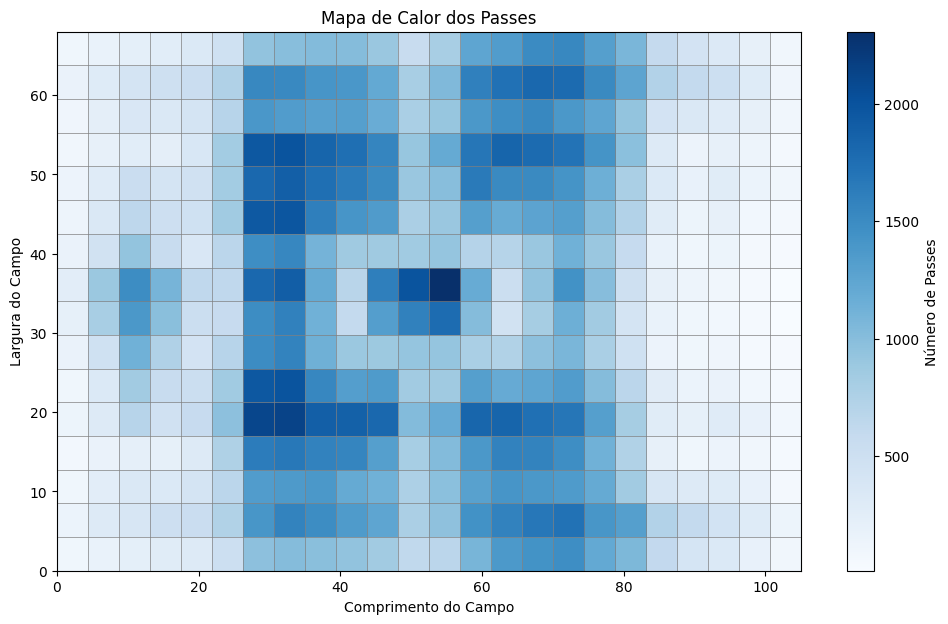

In [40]:
england_passes = spadl['England'][spadl['England']['type_name'] == 'pass']
plot_pass_heatmap(england_passes)

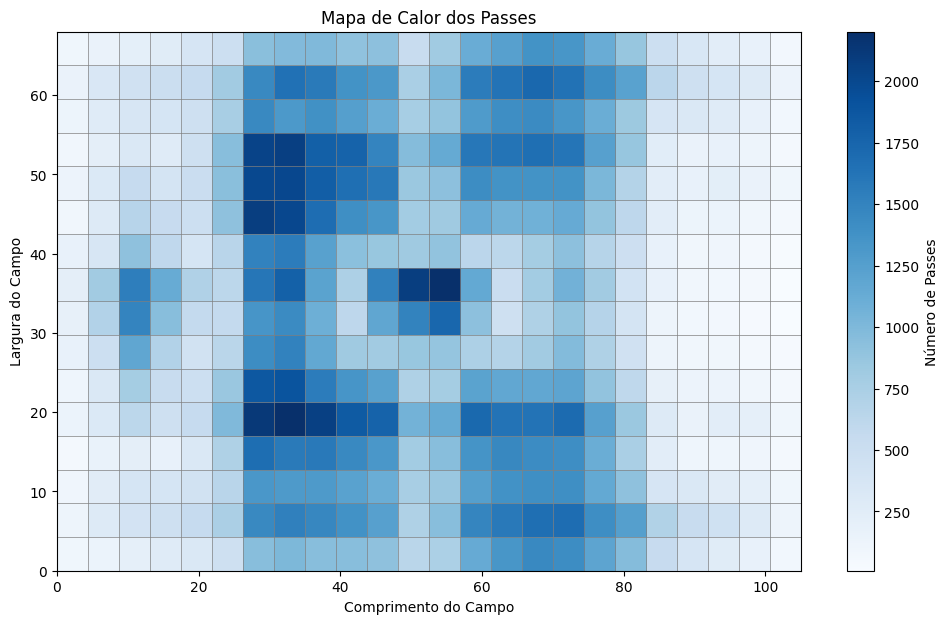

In [41]:
spain_passes = spadl['Spain'][spadl['Spain']['type_name'] == 'pass']
plot_pass_heatmap(spain_passes)

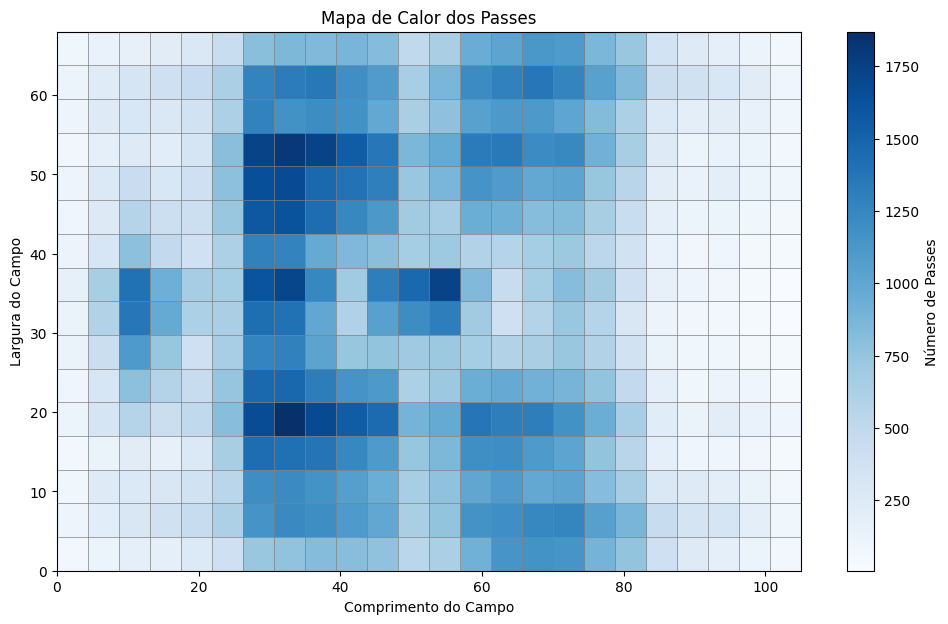

In [42]:
germany_passes = spadl['Germany'][spadl['Germany']['type_name'] == 'pass']
plot_pass_heatmap(germany_passes)

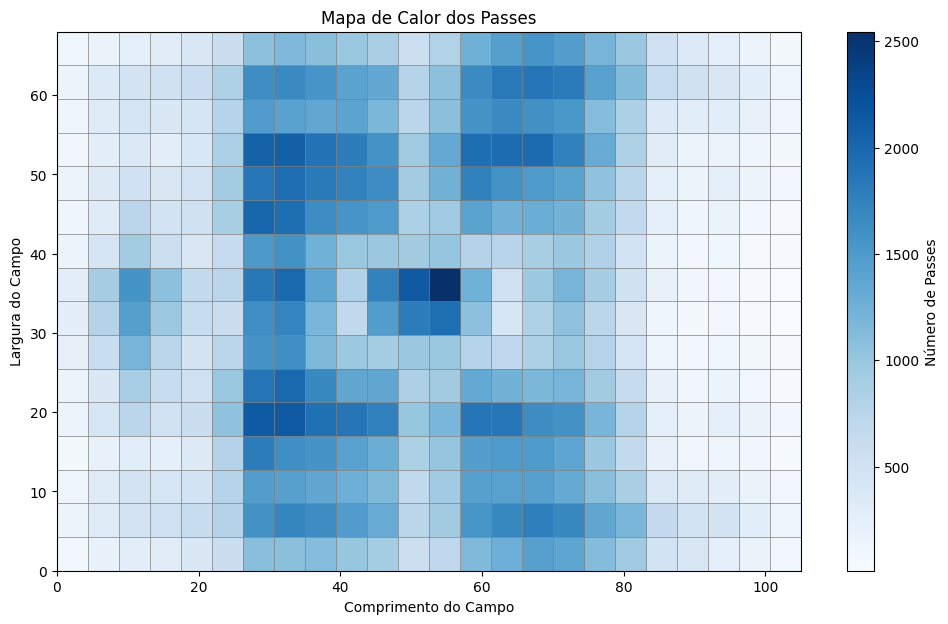

In [43]:
italy_passes = spadl['Italy'][spadl['Italy']['type_name'] == 'pass']
plot_pass_heatmap(italy_passes)

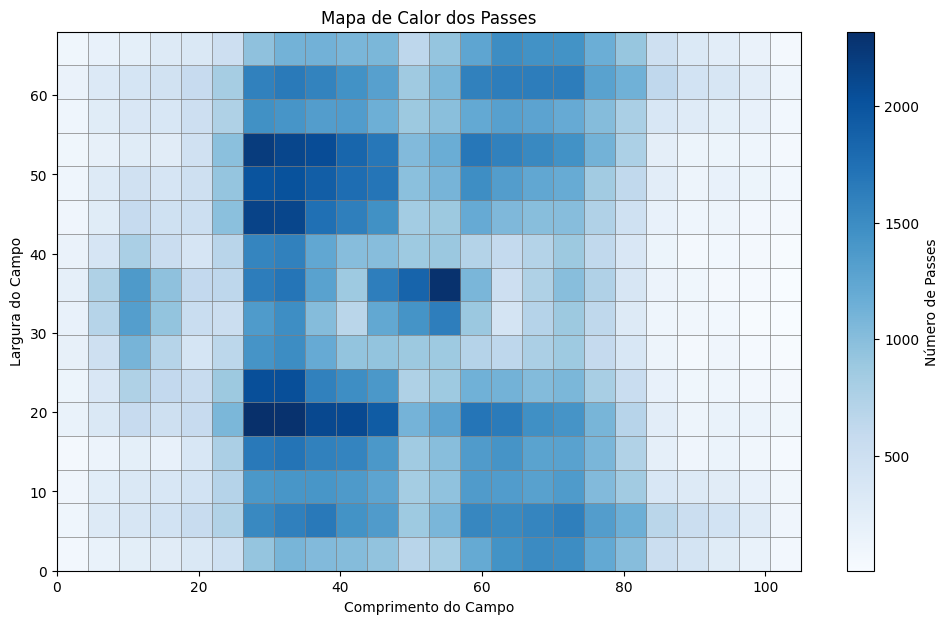

In [44]:
france_passes = spadl['France'][spadl['France']['type_name'] == 'pass']
plot_pass_heatmap(france_passes)

### Sequência: Ações que Levaram a Gol

Histograma com a frequência de cada tipo de ação executada que precedeu um gol.

Observações:
- Passes e cruzamentos lideram como ações que precedem gols;
- Bolas carregadas não resultam em tantos gols;
- Na La Liga, rebotes tendem a gerar mais gols do que escanteios.

In [45]:
def plot_action_sequences(action_sequences):
    plt.figure(figsize=(10, 6))
    action_sequences.plot(kind='bar', color='orange')
    plt.title('Tipo de Ação Imediatamente Antes do Gol (feito a partir de um chute)')
    plt.xlabel('Tipo de Ação')
    plt.ylabel('Frequência')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

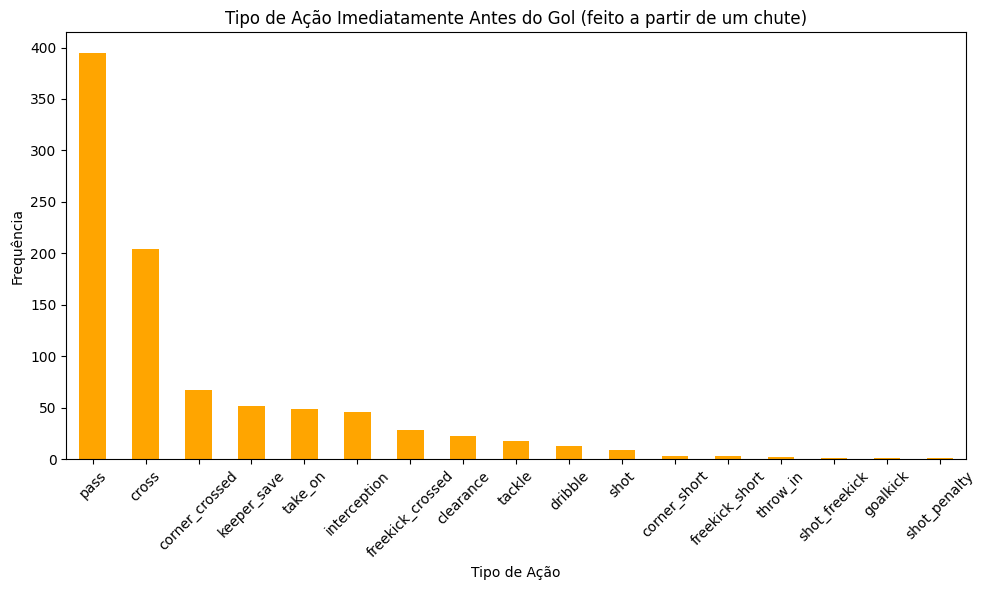

In [46]:
goal_indices = spadl['England'][(spadl['England']['type_name'] == 'shot') & (spadl['England']['result_name'] == 'success')].index
pre_goal_actions = spadl['England'].loc[goal_indices - 1]
action_sequences = pre_goal_actions['type_name'].value_counts()
plot_action_sequences(action_sequences)

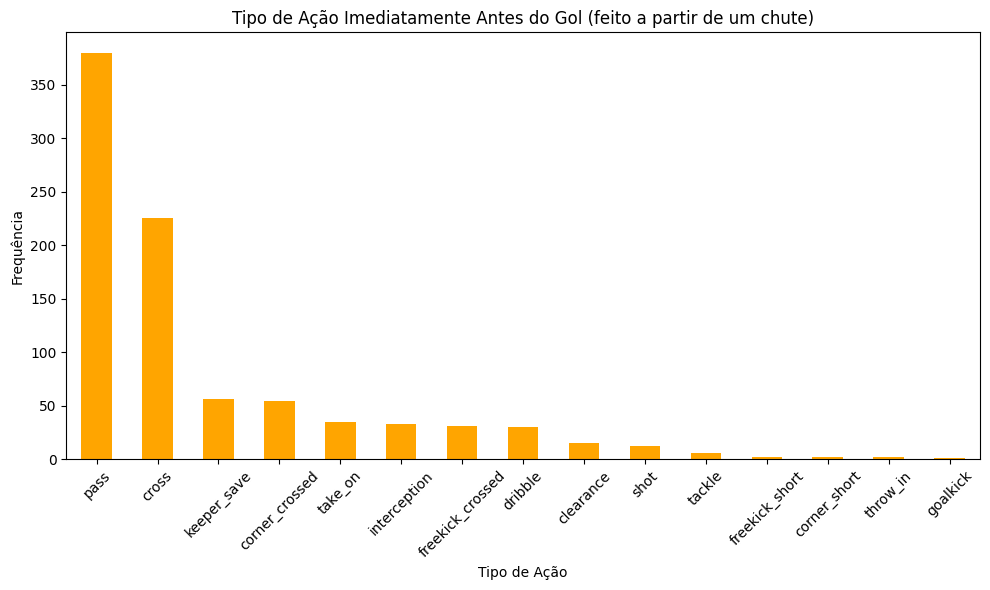

In [47]:
goal_indices = spadl['Spain'][(spadl['Spain']['type_name'] == 'shot') & (spadl['Spain']['result_name'] == 'success')].index
pre_goal_actions = spadl['Spain'].loc[goal_indices - 1]
action_sequences = pre_goal_actions['type_name'].value_counts()
plot_action_sequences(action_sequences)

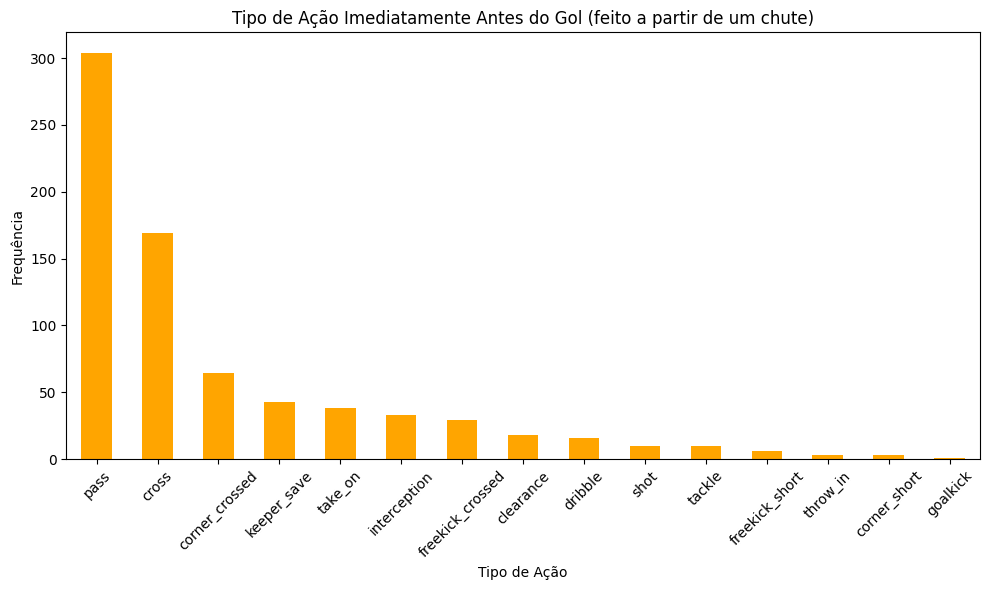

In [48]:
goal_indices = spadl['Germany'][(spadl['Germany']['type_name'] == 'shot') & (spadl['Germany']['result_name'] == 'success')].index
pre_goal_actions = spadl['Germany'].loc[goal_indices - 1]
action_sequences = pre_goal_actions['type_name'].value_counts()
plot_action_sequences(action_sequences)

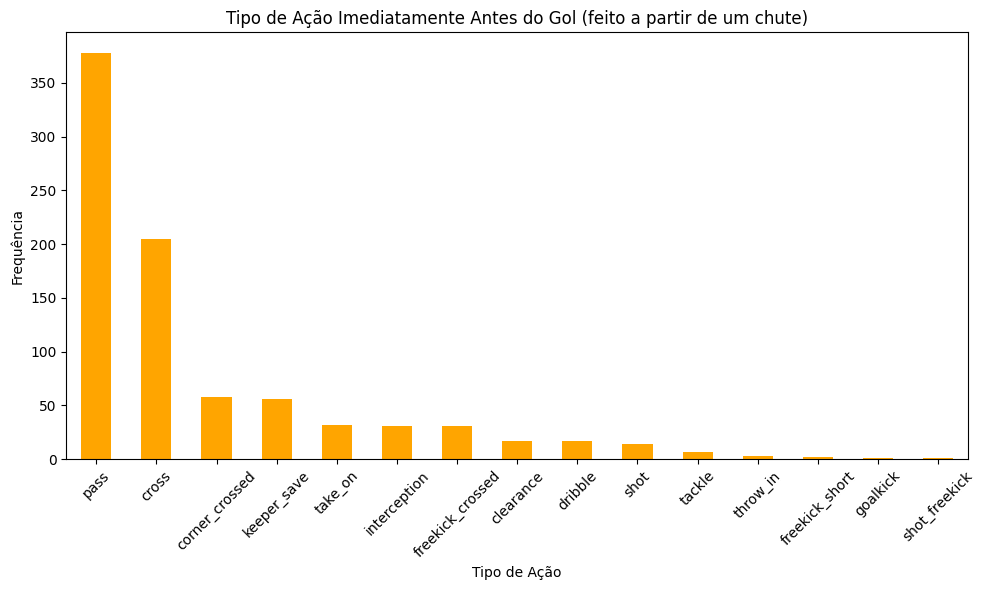

In [49]:
goal_indices = spadl['Italy'][(spadl['Italy']['type_name'] == 'shot') & (spadl['Italy']['result_name'] == 'success')].index
pre_goal_actions = spadl['Italy'].loc[goal_indices - 1]
action_sequences = pre_goal_actions['type_name'].value_counts()
plot_action_sequences(action_sequences)

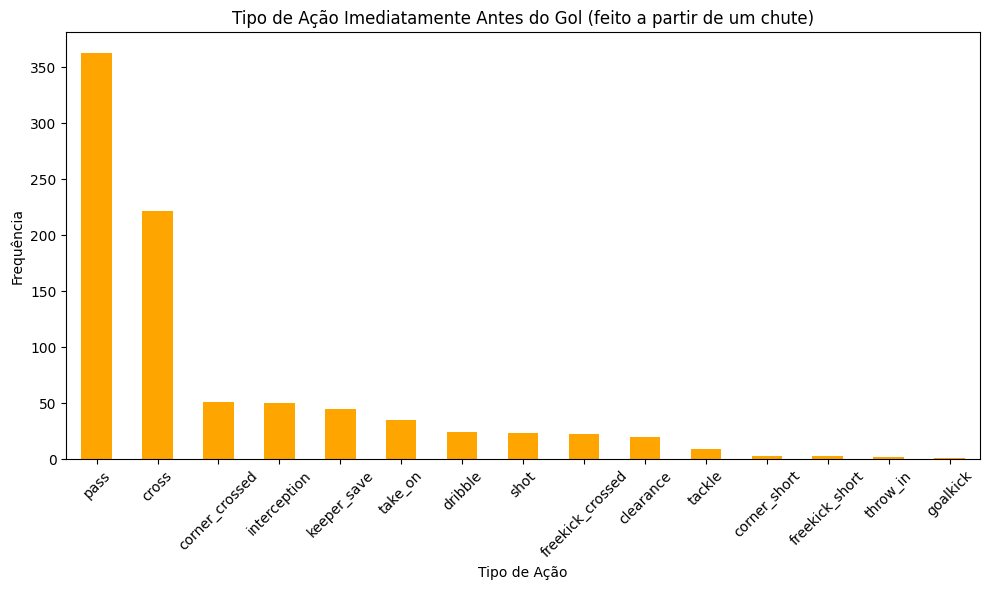

In [50]:
goal_indices = spadl['France'][(spadl['France']['type_name'] == 'shot') & (spadl['France']['result_name'] == 'success')].index
pre_goal_actions = spadl['France'].loc[goal_indices - 1]
action_sequences = pre_goal_actions['type_name'].value_counts()
plot_action_sequences(action_sequences)

### Mapa de Calor de Finalizações

Mapa de calor com as finalizações realizadas na liga.

Observações:
- As 5 ligas seguem o mesmo padrão de finalizações.

In [51]:
def plot_shot_heatmap(shots):
    n_x, n_y = 24, 16
    x_bins = np.linspace(0, 105, n_x + 1)
    y_bins = np.linspace(0, 68, n_y + 1)
    
    # Conta quantos passes começaram em cada quadrante
    heatmap, _, _ = np.histogram2d(shots['start_y'], shots['start_x'], bins=[y_bins, x_bins])
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 7))
    im = ax.imshow(heatmap, cmap='Reds', origin='lower', extent=[0, 105, 0, 68], aspect='auto')
    
    # Adiciona a grade
    for x in x_bins:
        ax.axvline(x, color='gray', linewidth=0.5)
    for y in y_bins:
        ax.axhline(y, color='gray', linewidth=0.5)
    
    # Rótulos e título
    plt.title('Mapa de Calor de Finalizações')
    ax.set_xlabel('Comprimento do Campo')
    ax.set_ylabel('Largura do Campo')
    fig.colorbar(im, ax=ax, label='Número de Chutes')
    plt.show()

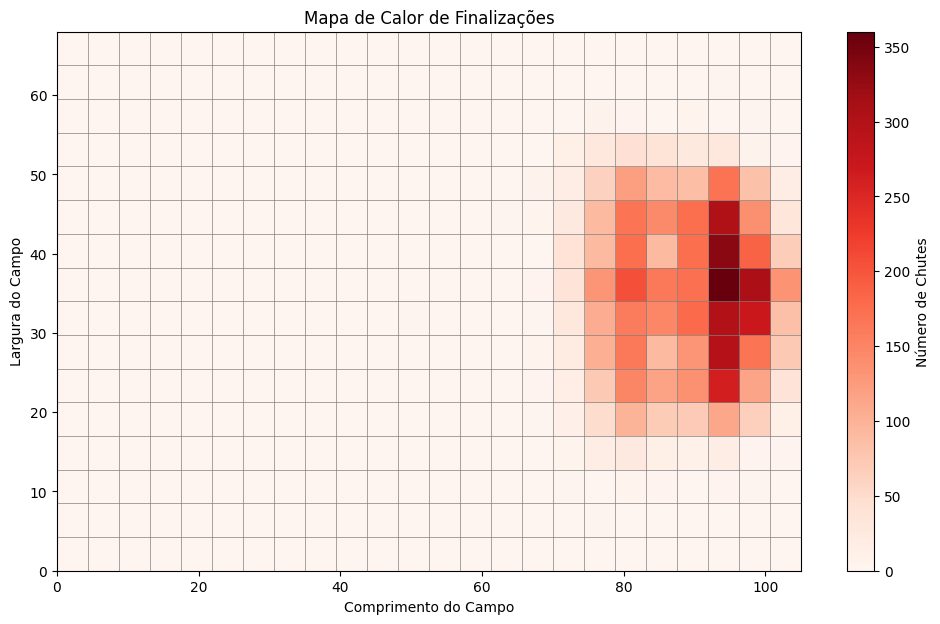

In [52]:
plot_shot_heatmap(spadl['England'][spadl['England']['type_name'] == 'shot'])

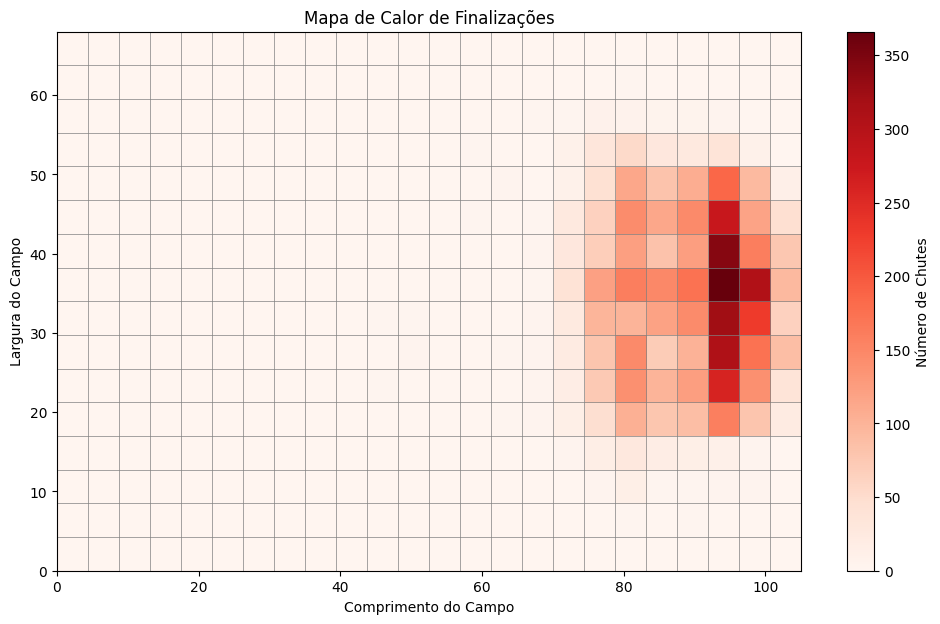

In [53]:
plot_shot_heatmap(spadl['Spain'][spadl['Spain']['type_name'] == 'shot'])

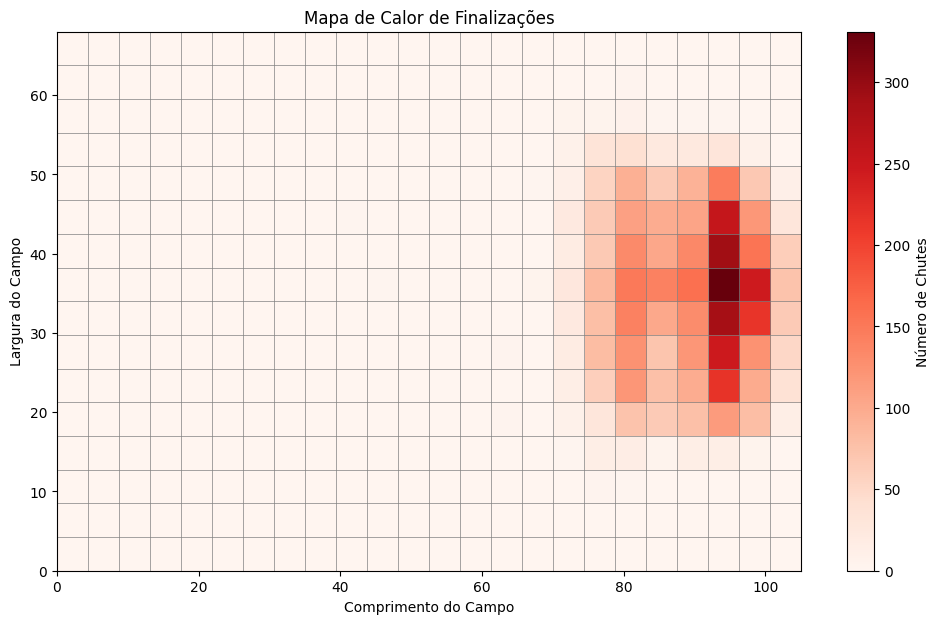

In [54]:
plot_shot_heatmap(spadl['Germany'][spadl['Germany']['type_name'] == 'shot'])

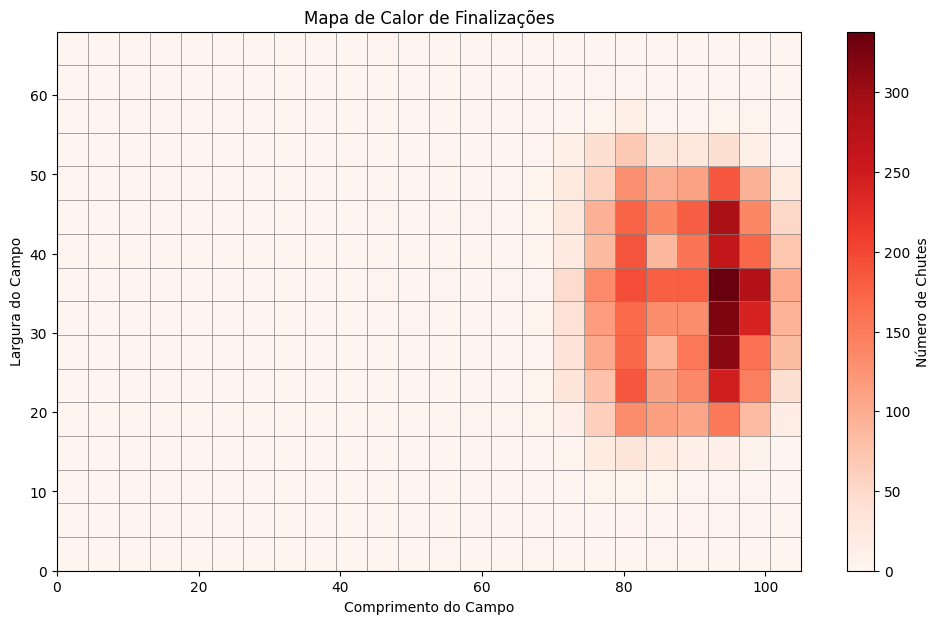

In [55]:
plot_shot_heatmap(spadl['Italy'][spadl['Italy']['type_name'] == 'shot'])

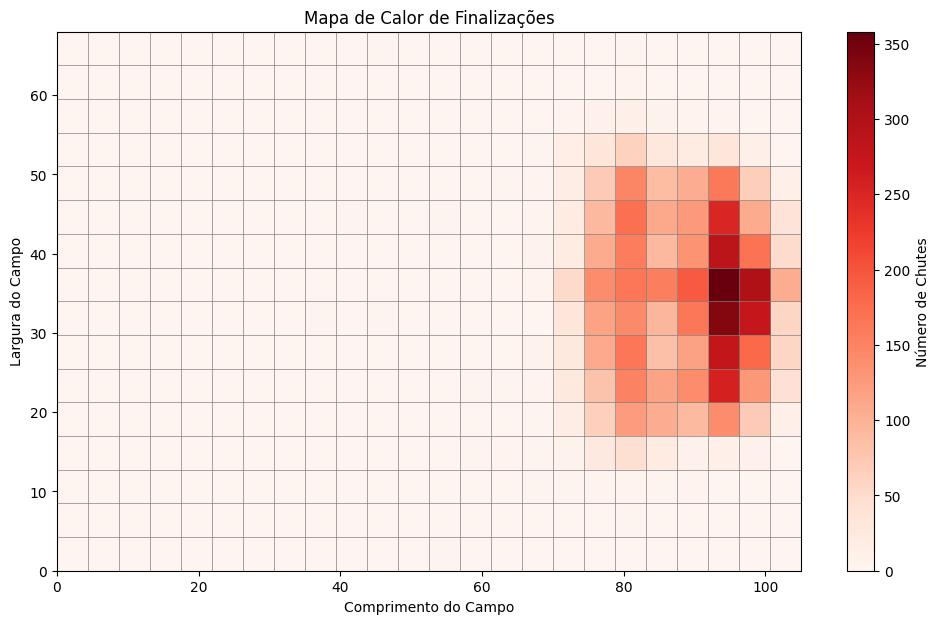

In [56]:
plot_shot_heatmap(spadl['France'][spadl['France']['type_name'] == 'shot'])

### Mapa de Assistências

Mapa com as setas que indicam passes que antecedem um chute.

Observações:
- Apenas uma amostra das assistências foram plotadas, para evitar poluição;
- As assistências precedem chutes contra o gol adversário, majoritariamente;
- Os chutes em sequência partem principalmente da grande área do goleiro adversário.

In [57]:
def plot_assists_heatmap(assists):
    plt.figure(figsize=(12, 7))
    for _, row in assists.iterrows():
        plt.arrow(row['start_x'], row['start_y'], 
                  row['end_x'] - row['start_x'], row['end_y'] - row['start_y'], 
                  head_width=1, head_length=1, color='green', alpha=0.5)
    
    plt.title('Passes que Antecederam Chutes')
    plt.xlim(0, 105)
    plt.ylim(0, 68)
    plt.gca().set_aspect('equal')
    plt.show()

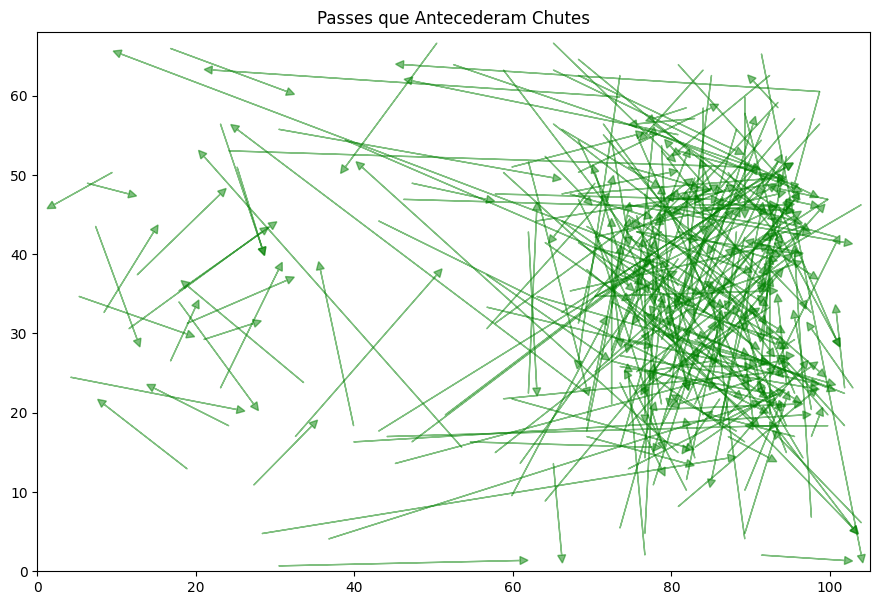

In [58]:
shot_idx = spadl['England'][spadl['England']['type_name'] == 'shot'].index
assist_idx = shot_idx - 1
assists = spadl['England'].loc[assist_idx][spadl['England'].loc[assist_idx]['type_name'] == 'pass']
plot_assists_heatmap(assists.head(300))

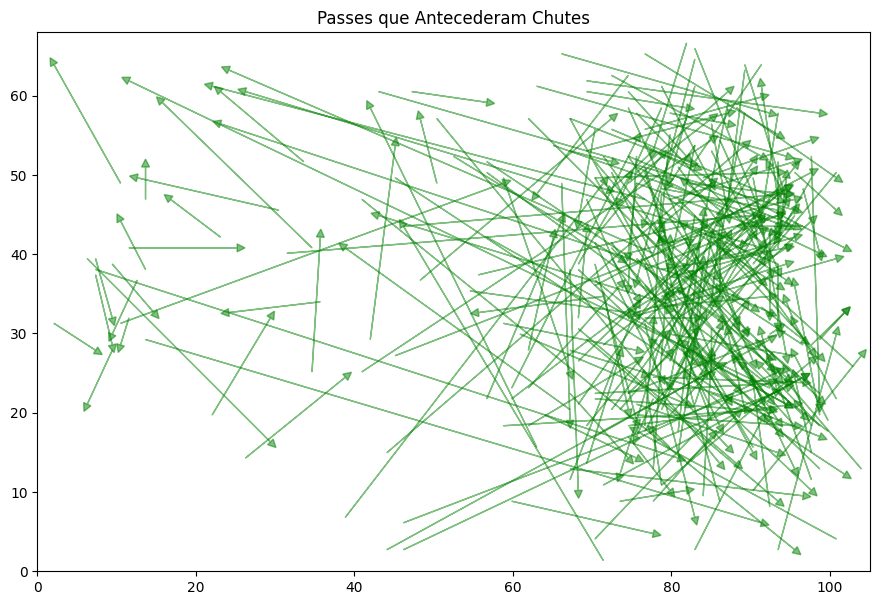

In [59]:
shot_idx = spadl['Spain'][spadl['Spain']['type_name'] == 'shot'].index
assist_idx = shot_idx - 1
assists = spadl['Spain'].loc[assist_idx][spadl['Spain'].loc[assist_idx]['type_name'] == 'pass']
plot_assists_heatmap(assists.head(300))

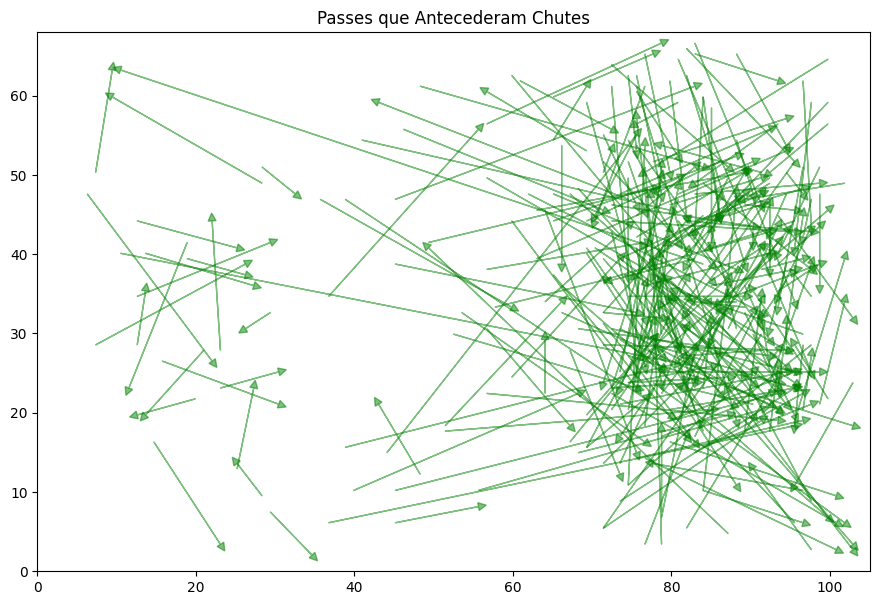

In [60]:
shot_idx = spadl['Germany'][spadl['Germany']['type_name'] == 'shot'].index
assist_idx = shot_idx - 1
assists = spadl['Germany'].loc[assist_idx][spadl['Germany'].loc[assist_idx]['type_name'] == 'pass']
plot_assists_heatmap(assists.head(300))

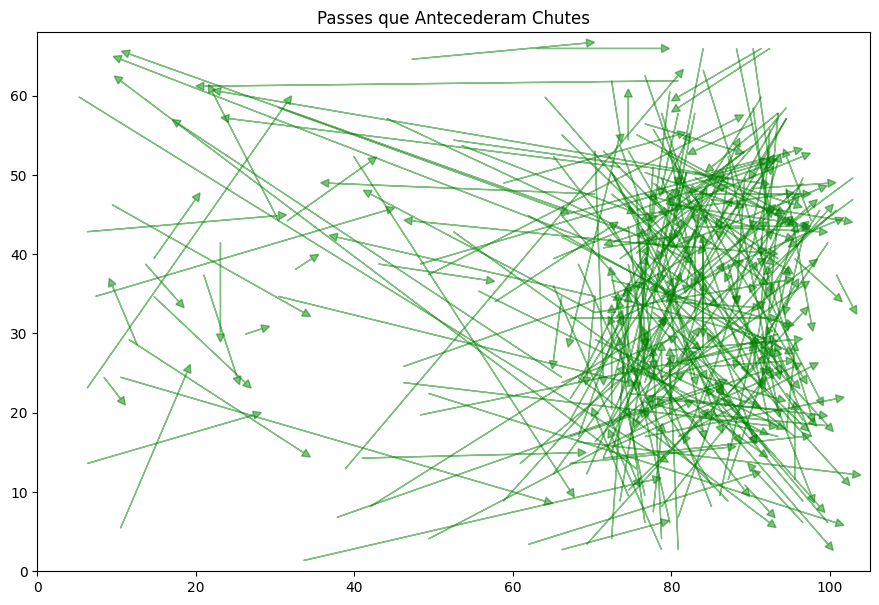

In [61]:
shot_idx = spadl['Italy'][spadl['Italy']['type_name'] == 'shot'].index
assist_idx = shot_idx - 1
assists = spadl['Italy'].loc[assist_idx][spadl['Italy'].loc[assist_idx]['type_name'] == 'pass']
plot_assists_heatmap(assists.head(300))

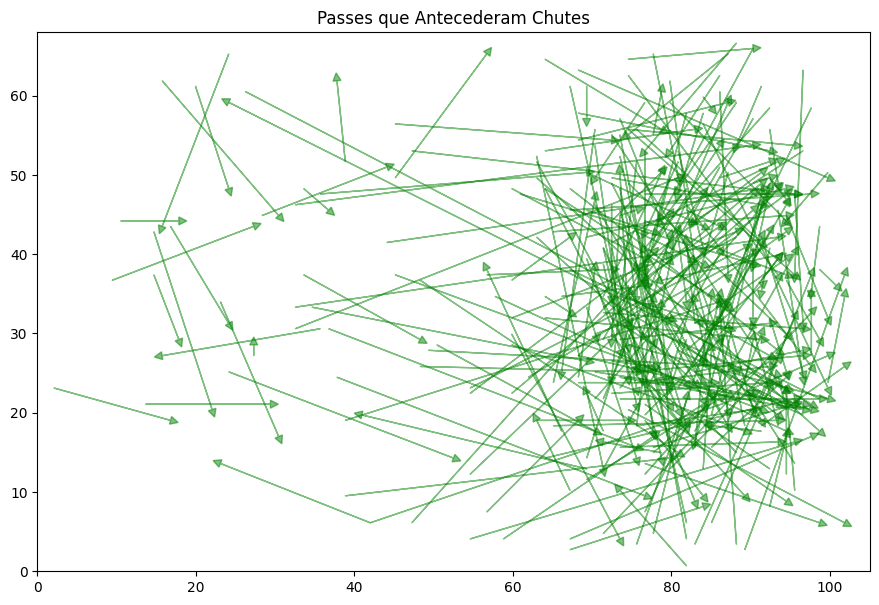

In [62]:
shot_idx = spadl['France'][spadl['France']['type_name'] == 'shot'].index
assist_idx = shot_idx - 1
assists = spadl['France'].loc[assist_idx][spadl['France'].loc[assist_idx]['type_name'] == 'pass']
plot_assists_heatmap(assists.head(300))